In [1]:
# import libraries

import numpy as np
import os
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode

Index(['County', 'STATE_NAME', 'STATE_ABBR', 'STATE_FIPS', 'COUNTY_FIP',
       'FIPS', 'POPULATION', 'POP_SQMI', 'SQMI', 'Shape__Are', 'Shape__Len',
       'geometry'],
      dtype='object')


c:\Users\rmonaghan\AppData\Local\anaconda3\envs\working\Lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

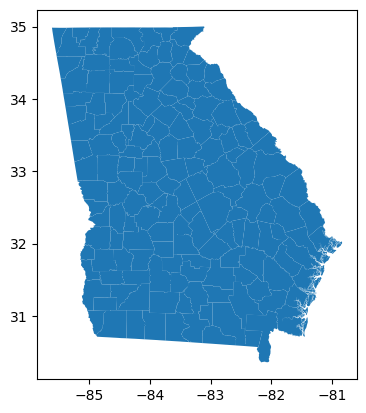

In [6]:
# upload shapefile with counties

state_path = "F:/RMonaghan_Workspace/Projects/Peeps/George/GA_Counties/dtl_cnty.shp"
GA_counties = gpd.read_file(state_path).rename(columns={'NAME':'County'})

print(GA_counties.columns)
GA_counties.plot()

In [7]:
# add filepaths of csvs to list

csv_path = "F:/RMonaghan_Workspace/Projects/Peeps/George"

lis = []

for r, d, f in os.walk(csv_path):
    for file in f:
        if file.endswith('csv'):
            lis.append(os.path.join(r, file))

lis

['F:/RMonaghan_Workspace/Projects/Peeps/George\\Bought2Burn.csv',
 'F:/RMonaghan_Workspace/Projects/Peeps/George\\GABurnerJune.csv']

In [8]:
# open each filepath for csv and add each created dataframe to list
dfs = [pd.read_csv(i) for i in lis]

# make acre column uniform
dfs[0].rename(columns={'How many Acres do you manage or help manage?':'ac'}, inplace=True)
dfs[1].rename(columns={'How many acres do you help manage?':'ac'}, inplace=True)

# create an address column for geocoding
dfs[0]['add'] = dfs[1]['Address 1:'] + ' ' + dfs[0]['City:'] + ', ' + dfs[0]['State:']
dfs[1]['add'] = dfs[1]['Address 1:'] + ' ' + dfs[1]['City:'] + ', ' + dfs[1]['State:']

In [9]:
# connect to MapBox geocder API to geocode addresses
# this is a public API key and will work for anyone
key = 'pk.eyJ1Ijoicm1vbmFnaGFuIiwiYSI6ImNsaHJ1YmdvaTB3NHczcW4wOGhhNHQ1OWgifQ.eDG_Z1em7PZEXxOY1WvuCg'

# function to geocode and add geometry to dfs
def add_geometry(address_column, df):
    address_lis = address_column.fillna('').to_list()
    gcoded = [geocode(i, provider='mapbox', api_key=key, timeout=4) for i in address_lis]

    geom = []
    for i in range(len(gcoded)):
        geom.append(gcoded[i].geometry)

    geom_df = pd.DataFrame(geom).rename(columns={0:'geometry'}).reset_index().loc[:, 'geometry']
    df['geometry'] = geom_df

    return df

# function to spatial join with counties (still keeping it as pt data for a bit)
def sjoining(df, counties):
    gdf = gpd.GeoDataFrame(df, geometry=df.geometry, crs='EPSG:4326').to_crs(counties.crs)
    sjoined = gpd.sjoin(gdf, counties, how='left')
    sjoined = sjoined.fillna(0)

    return sjoined


In [10]:
# run functions over both dfs

gdfs = [add_geometry(i['add'], i) for i in dfs]
sjoined = [sjoining(i, GA_counties) for i in gdfs]

In [11]:
# rename a column for uniformity

sjoined[0] = sjoined[0].rename(columns={"County_right":'County'})
merged = pd.concat(sjoined)

In [12]:
# examine the # of rows where a county name exists

merged.query('County.notnull()')

First Name: Last Name:             Email Address:               Address 1:  \
0          Ken     Andrew         ken@andrewtent.com         2134 DE Short Rd   
1         Kurt     Fowler         kurtfowler@aol.com       324 Mud Creek Road   
2         Lisa    Giencke                          0   1465 Milford Church Rd   
3       Donald    Griffin          dgriffin@rose.net      706 crabapple drive   
4    Elizabeth    Harrell        eaharrell@gmail.com           4655 DILLON RD   
..         ...        ...                        ...                      ...   
44      Jayden   Mitchell        bass32008@gmail.com       979 annie mcgee rd   
45        Douy       Reed  douglasreed1392@gmail.com  999 nochaway main drive   
46        Anne     Thomas       annethomas@mchsi.com           P. O. Box 6144   
47        Kyle  McPherson             kyle@wtsinc.us              PO Box 4199   
48       Damon      Deese         ddeese37@gmail.com               PO Box 595   

          City:  ZIP Code:   State:    County_left     ac  \
0        Dawson    39842.0  Georgia        Terrell  201.0   
1        Albany    31721.0  Georgia      Dougherty  605.0   
2       Milford    39862.0  Georgia          Baker    0.0   
3   thomasville    31757.0  Georgia         thomas  200.0   
4   Thomasville    31757.0  Georgia  United States  100.0   
..          ...        ...      ...            ...    ...   
44     moultrie    31788.0  Georgia            NaN     10   
45     Leary,ga    39862.0  Georgia            NaN   6000   
46     Americus    31709.0  Georgia            NaN   5600   
47   Plant City    33563.0  Florida            NaN   1400   
48       Newton    39870.0  Georgia            NaN   1000   

                               I want to attend  ... COUNTY_FIP   FIPS  \
0   Both the training and the quarterly meeting  ...        273  13273   
1   Both the training and the quarterly meeting  ...        095  13095   
2                                             0  ...        067  13067   
3                                             0  ...        103  13103   
4   Both the training and the quarterly meeting  ...        027  13027   
..                                          ...  ...        ...    ...   
44                                          NaN  ...        071  13071   
45                                          NaN  ...        037  13037   
46                                          NaN  ...        241  13241   
47                                          NaN  ...          0      0   
48                                          NaN  ...        103  13103   

   POPULATION POP_SQMI    SQMI  Shape__Are  Shape__Len          Address 2:  \
0      9185.0     27.2  337.70    0.083276    1.531855                 NaN   
1     85790.0    256.4  334.57    0.082292    1.443714                 NaN   
2    766149.0   2223.6  344.55    0.087023    1.304192                 NaN   
3     64769.0    134.1  482.90    0.119839    2.063414                 NaN   
4     16301.0     32.7  497.80    0.121567    2.150068                 NaN   
..        ...      ...     ...         ...         ...                 ...   
44    45898.0     82.5  556.64    0.136421    1.727221  979 annie mcgee rd   
45     5573.0     19.7  283.58    0.069747    1.500212                   0   
46    16883.0     44.8  377.03    0.096283    1.881217                   0   
47        0.0      0.0    0.00    0.000000    0.000000                   0   
48    64769.0    134.1  482.90    0.119839    2.063414   444 Sunset Avenue   

     Cell Phone:  Are you considered historically underserved?  
0            NaN                                           NaN  
1            NaN                                           NaN  
2            NaN                                           NaN  
3            NaN                                           NaN  
4            NaN                                           NaN  
..           ...                                           ...  
44    2293199283

In [19]:
# replace every 0 in the counties column with null
merged['County'].replace(0, np.nan, inplace=True)

# before computing mean, remove thousands comma so reads in as numeric
merged['ac'] = merged['ac'].str.replace(',', '').astype(float)

# groupby County and comute mean
grouped = merged.groupby('County').agg(
            ac_mean=('ac', np.mean), 
            ac_sum=('ac', np.sum))

grouped


ac_mean   ac_sum
County                             
Baker County      1800.000   5400.0
Brooks County       80.000     80.0
Calhoun County    6000.000   6000.0
Cobb County            NaN      0.0
Colquitt County   2752.500  11010.0
Dougherty County  7062.875  56503.0
Early County      1000.000   1000.0
Effingham County  1000.000   1000.0
Grady County           NaN      0.0
Lee County        6750.000  13500.0
Miller County     1500.000   1500.0
Mitchell County    275.000    275.0
Rabun County      5600.000   5600.0
Terrell County         NaN      0.0
Thomas County     4169.800  41698.0
Tift County            NaN      0.0
Worth County      3000.000   3000.0

c:\Users\rmonaghan\AppData\Local\anaconda3\envs\working\Lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

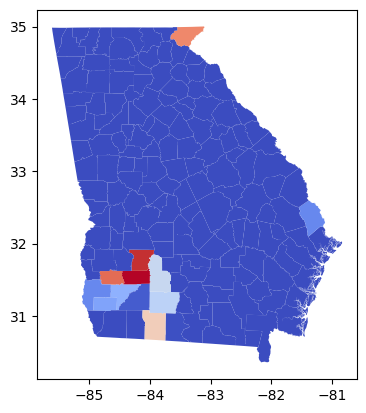

In [24]:
# now take point data and connect with GA counties geometry
# join type here is outer, in order to return geometry for all counties
# even those that don't have an 'ac' value
# to retain only those with 0+ vals, change "how" to "inner"
grouped_sjoined = pd.merge(GA_counties, grouped, on='County', how='outer')

# replace nulls in ac column with 0
grouped_sjoined.fillna(0, inplace=True)

# viz
grouped_sjoined.plot(column='ac_mean', cmap='coolwarm')

In [25]:
# refine columns 
# add other columns here if too sparse
# look at column types
final = grouped_sjoined.reset_index()[['County', 'ac_mean', 'ac_sum', 'geometry']].set_index('County')
final.dtypes

ac_mean      float64
ac_sum       float64
geometry    geometry
dtype: object

In [26]:
# exported
final.to_file('GA_Counties_mean_ac.shp', engine='pyogrio', driver='ESRI Shapefile')